# Z3 SMT Exercises

> Before trying to solve the exercises contained in this notebook, the reader is suggested to have gained experience with the tool through the `Z3 Tutorial.ipynb` notebook.

In [1]:
from z3 import *
from utils import *

## Sudoku

In [2]:
# Sudoku instances, '0's correspond to empty cells

instance1 = ((0, 0, 0, 0, 9, 4, 0, 3, 0),
             (0, 0, 0, 5, 1, 0, 0, 0, 7),
             (0, 8, 9, 0, 0, 0, 0, 4, 0),
             (0, 0, 0, 0, 0, 0, 2, 0, 8),
             (0, 6, 0, 2, 0, 1, 0, 5, 0),
             (1, 0, 2, 0, 0, 0, 0, 0, 0),
             (0, 7, 0, 0, 0, 0, 5, 2, 0),
             (9, 0, 0, 0, 6, 5, 0, 0, 0),
             (0, 4, 0, 9, 7, 0, 0, 0, 0))

instance2 = ((0, 0, 0, 0, 9, 0, 1, 0, 0),
             (2, 8, 0, 0, 0, 5, 0, 0, 0),
             (7, 0, 0, 0, 0, 6, 4, 0, 0),
             (8, 0, 5, 0, 0, 3, 0, 0, 6),
             (0, 0, 1, 0, 0, 4, 0, 0, 0),
             (0, 7, 0, 2, 0, 0, 0, 0, 0),
             (3, 0, 0, 0, 0, 1, 0, 8, 0),
             (0, 0, 0, 0, 0, 0, 0, 5, 0),
             (0, 9, 0, 0, 0, 0, 0, 7, 0))

instance3 = ((0, 7, 0, 0, 0, 0, 0, 4, 9),
             (0, 0, 0, 4, 0, 0, 0, 0, 0),
             (4, 0, 3, 5, 0, 7, 0, 0, 8),
             (0, 0, 7, 2, 5, 0, 4, 0, 0),
             (0, 0, 0, 0, 0, 0, 8, 0, 0),
             (0, 0, 4, 0, 3, 0, 5, 9, 2),
             (6, 1, 8, 0, 0, 0, 0, 0, 5),
             (0, 9, 0, 1, 0, 0, 0, 3, 0),
             (0, 0, 5, 0, 0, 0, 0, 0, 7))

instance4 = ((0, 0, 0, 0, 0, 6, 0, 0, 0),
             (0, 5, 9, 0, 0, 0, 0, 0, 8),
             (2, 0, 0, 0, 0, 8, 0, 0, 0),
             (0, 4, 5, 0, 0, 0, 0, 0, 0),
             (0, 0, 3, 0, 0, 0, 0, 0, 0),
             (0, 0, 6, 0, 0, 3, 0, 5, 4),
             (0, 0, 0, 3, 2, 5, 0, 0, 6),
             (0, 0, 0, 0, 0, 0, 0, 0, 0),
             (0, 0, 0, 0, 0, 0, 0, 0, 0))

In [3]:
def sudoku_smt(instance):
    # 9x9 matrix of integer variables
    v = [[Int("x_%s_%s" % (i+1, j+1)) for j in range(9)] for i in range(9)]

    # each cell contains a value in {1, ..., 9}
    cells_c = [And(1 <= v[i][j], v[i][j] <= 9)
               for i in range(9) for j in range(9)]

    # each row contains a digit at most once
    rows_c = [Distinct(v[i]) for i in range(9)]

    # each column contains a digit at most once
    cols_c = [Distinct([v[i][j] for i in range(9)]) for j in range(9)]

    # each 3x3 square contains a digit at most once
    sq_c = [Distinct([v[3*i0 + i][3*j0 + j] for i in range(3) for j in range(3)])
            for i0 in range(3) for j0 in range(3)]

    sudoku_c = cells_c + rows_c + cols_c + sq_c

    instance_c = [If(instance[i][j] == 0, True, v[i][j] == instance[i][j])
                  for i in range(9) for j in range(9)]

    s = Solver()
    s.add(sudoku_c + instance_c)

    if s.check() == sat:
        m = s.model()
        return [[int(m.evaluate(v[i][j]).as_string()) for j in range(9)] for i in range(9)]
    else:
        print("Failed to solve")

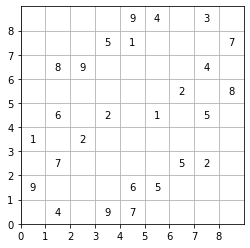

In [4]:
instance = instance1
display_sudoku(instance)

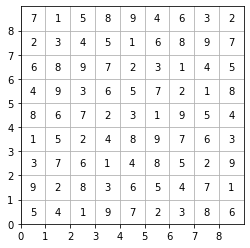

CPU times: user 611 ms, sys: 38.7 ms, total: 650 ms
Wall time: 654 ms


In [5]:
%%time
display_sudoku(sudoku_smt(instance))

## Scheduling

In [18]:
def max_z3(vars):
  max = vars[0]
  for v in vars[1:]:
    max = If(v > max, v, max)
  return max

def schedule(jobs):
    t = []
    for i, job in enumerate(jobs):
        t.append([])
        for j, _ in enumerate(job):
            t[i].append(Int(f"t{i}_{j}"))

    opt = Optimize()

    # Starting time of the task >= 0
    for job in t:
        for start_time in job:
            opt.add(start_time >= 0)

    # Precedence among the successive tasks of each job
    for i, job in enumerate(t):
        for j, (prev, succ) in enumerate(zip(job[:-1], job[1:])):
            opt.add(prev + jobs[i][j][1] <= succ)

    machines = set()
    for job in jobs:
        for task in job:
            machines.add(task[0])

    # Machines can only execute one task at a time
    machine_ctrs = []
    for machine in list(machines):
        machine_ctrs.append([])
        for i, job1 in enumerate(jobs):
            for j, task1 in enumerate(job1):
                for ii, job2 in enumerate(jobs):
                    for jj, task2 in enumerate(job2):
                        if (i < ii or j < jj) and task1[0] == task2[0] == machine:
                            machine_ctrs[machine].append(
                                Or(t[i][j] + task1[1] <= t[ii][jj],
                                   t[ii][jj] + task2[1] <= t[i][j])
                            )
    for ctrs_list in machine_ctrs:
        opt.add(And(ctrs_list))

    last_tasks = [start_list[-1] + job[-1][1] for job, start_list in zip(jobs, t)]

    total_time = Int('total_time')

    objective = total_time == max_z3(last_tasks)
    opt.add(objective)
    opt.minimize(total_time)
    opt.check()
    opt.lower()
    return opt.model()

In [19]:
j0 = [(0,3), (1,2), (2,2)]
j1 = [(0,2), (2,1), (1,4)]
j2 = [(1,4), (2,3)]
schedule([j0, j1, j2])

[t0_0 = 0,
 total_time = 11,
 t1_0 = 3,
 t0_2 = 6,
 t2_0 = 0,
 t1_1 = 5,
 t0_1 = 4,
 t1_2 = 6,
 t2_1 = 8]

## Program Equivalence

In [8]:
in0_a, out0_a, out1_a, out2_a = Ints("in0_a out0_a out1_a out2_a")
in0_b, out0_b = Ints("in0_b out0_b")

power3 = And(
    out0_a == in0_a,
    out1_a == out0_a * in0_a,
    out2_a == out1_a * in0_a
)

power3_new = out0_b == (in0_b * in0_b) * in0_b

prove(Implies(And(power3, power3_new, in0_a == in0_b), out2_a == out0_b))

proved
